In [1]:
!pwd

/home/exouser/Downloads


In [2]:
!ls

'projectV1Scenerio1 (1).ipynb'	 signals_exported.csv


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
data_df = pd.read_csv('signals_exported.csv')
data = data_df.drop(columns=['time'])

In [5]:
data.head()

,p_ref,speed_ref,v_ref,Rotor_speed__wm__pu_,Stator_voltage__vd__pu_,Stator_voltage__vq__pu_,Field_current__ifd__pu_,Rotor_speed_deviation__dw__pu_,Output_active_power___Peo__pu_,Output_reactive_power__Qeo__pu_,Rotor_mechanical_angle__theta__deg_,vt_mag_1,vt_mag_2,throttle,Efd
0,0.75,1,1,1.000000,0.000000,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.750000,0.000000
1,0.75,1,1,1.000057,0.209238,0.764461,1.092529,0.000057,0.537244,-0.037329,0.900030,0.209238,0.764461,0.744264,3.489654
2,0.75,1,1,1.000032,0.336198,0.660178,1.305155,0.000032,0.894142,-0.093348,1.800077,0.336198,0.660178,0.746796,6.024024
3,0.75,1,1,0.999937,0.439674,0.598169,1.644345,-0.000063,1.313625,-0.120563,2.700072,0.439674,0.598169,0.756291,5.893485
4,0.75,1,1,0.999782,0.378436,0.491368,2.052351,-0.000218,1.433991,0.066080,3.599957,0.378436,0.491368,0.771798,5.782580


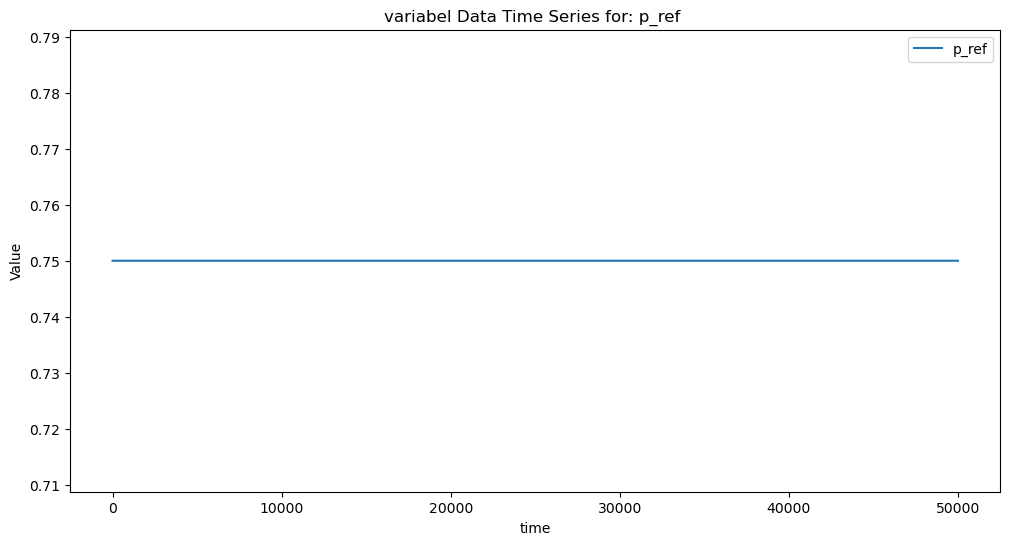

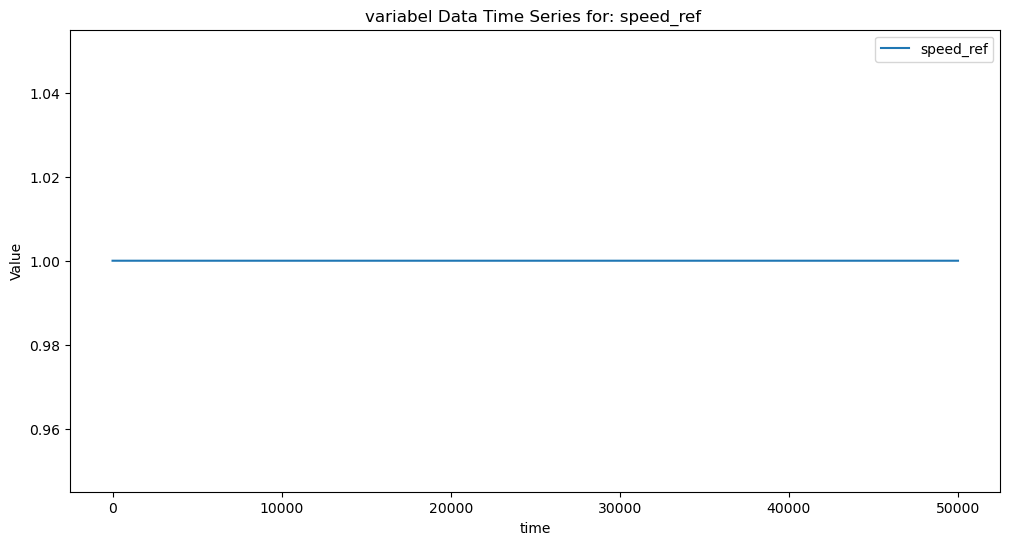

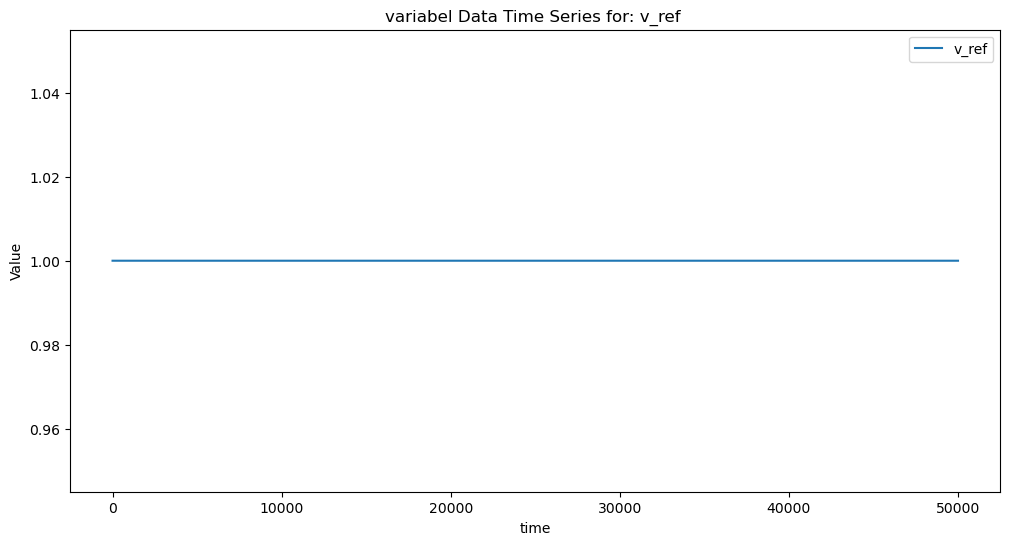

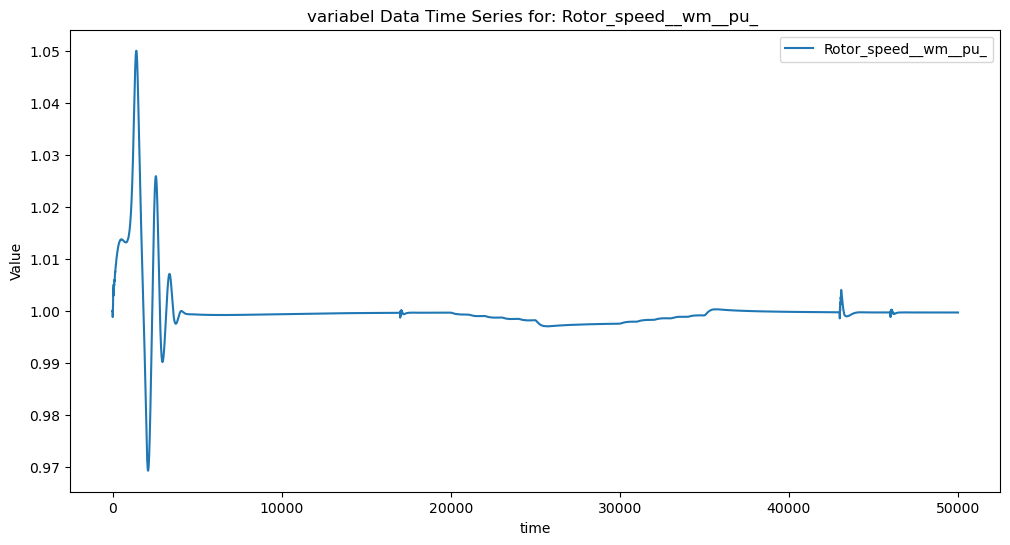

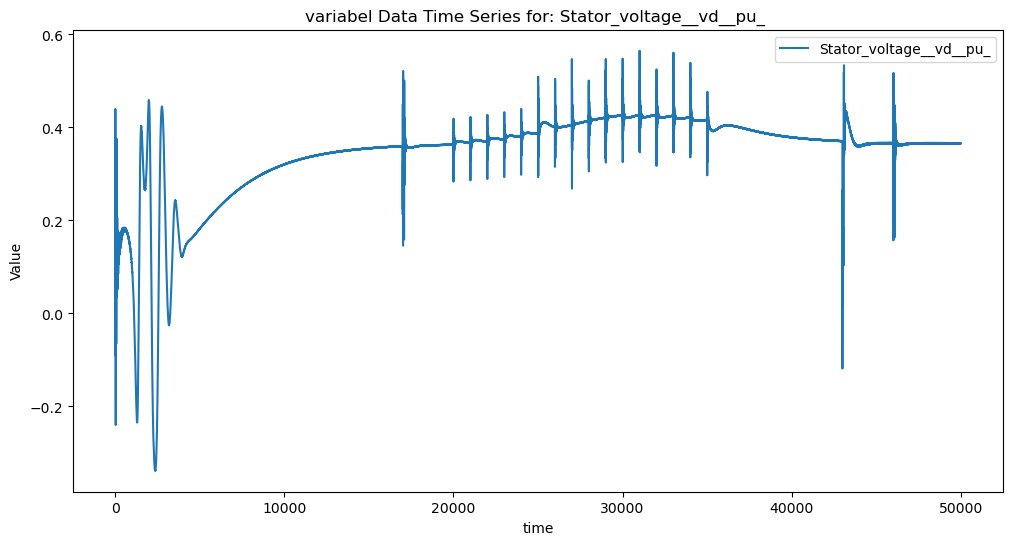

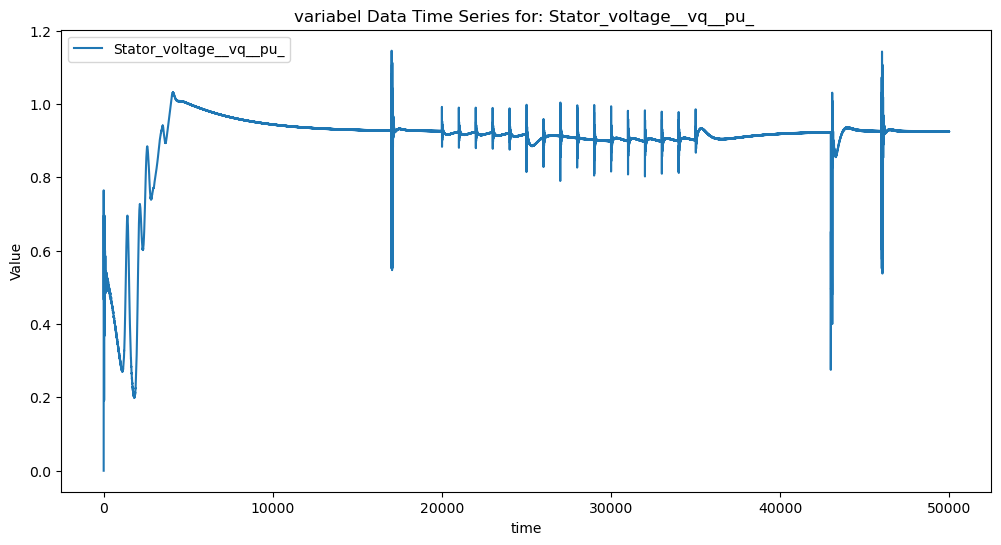

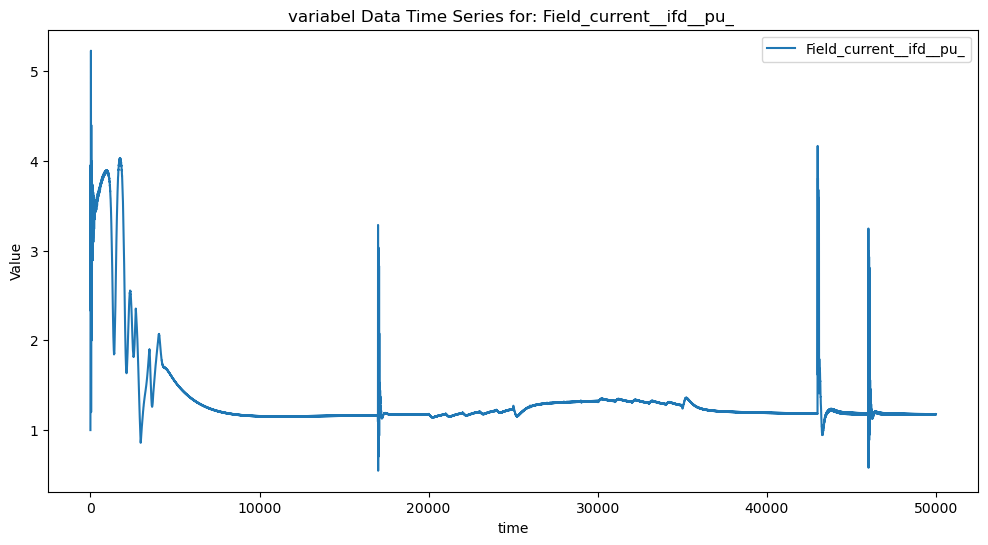

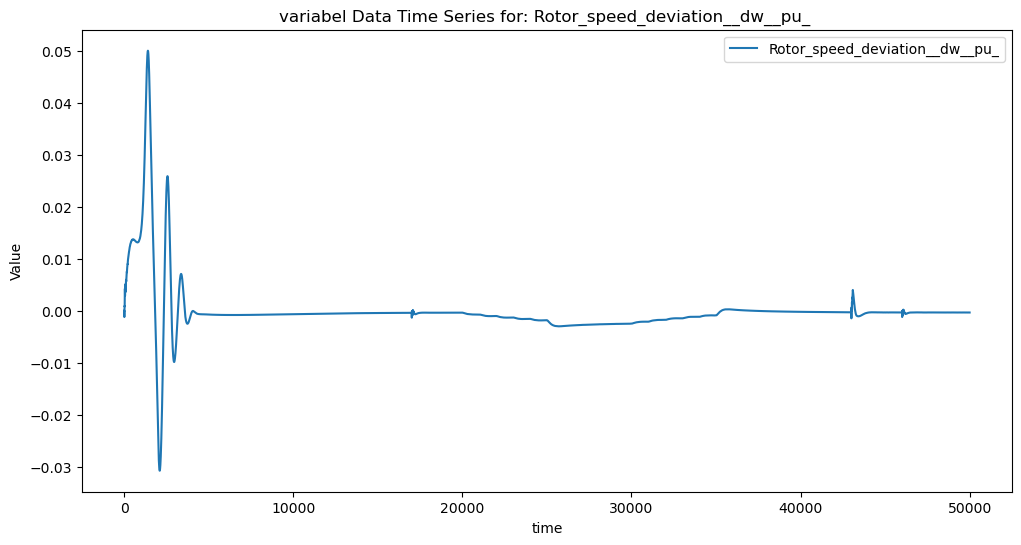

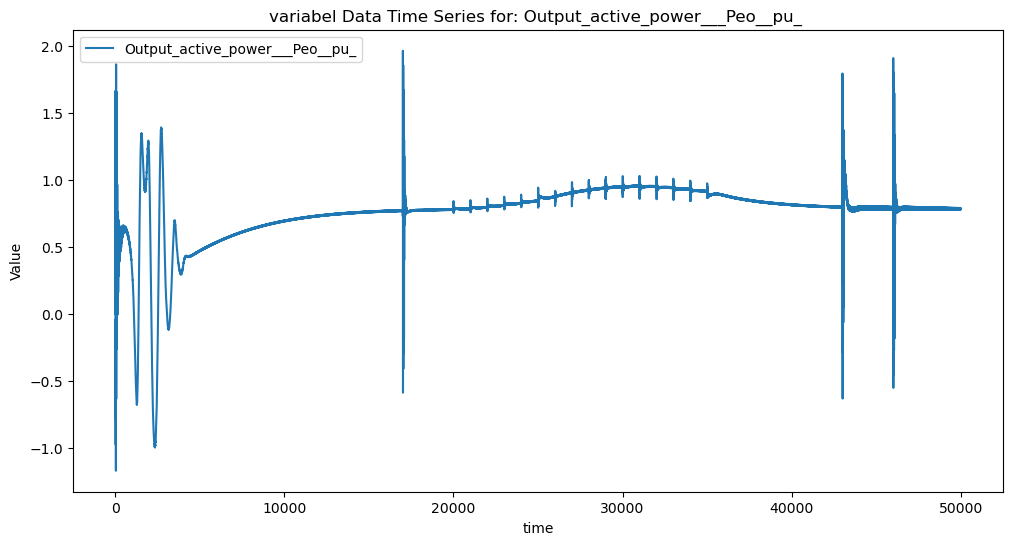

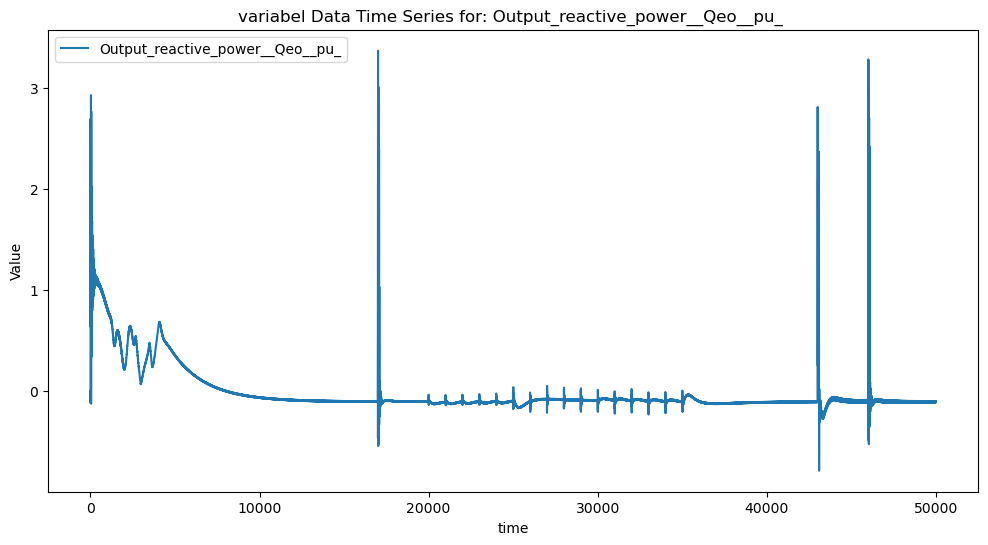

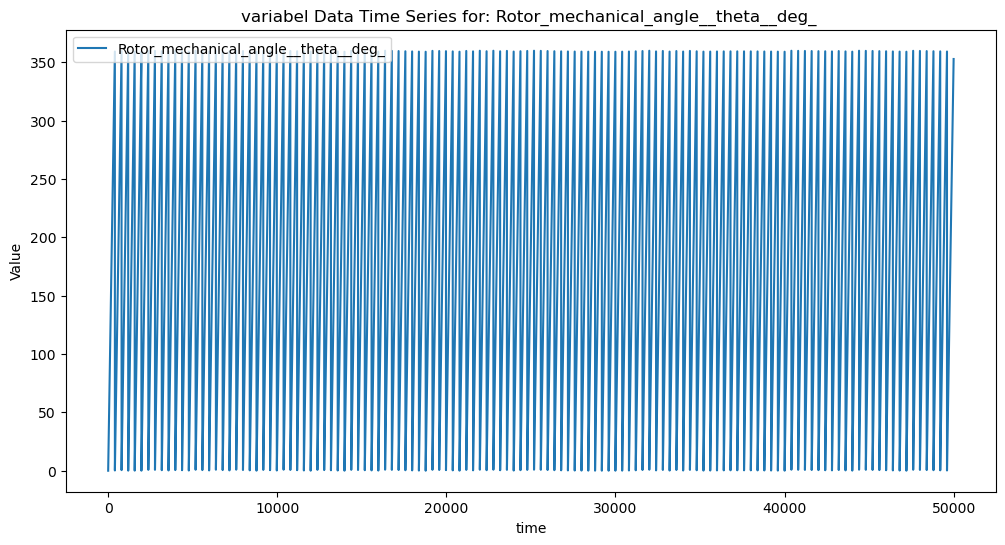

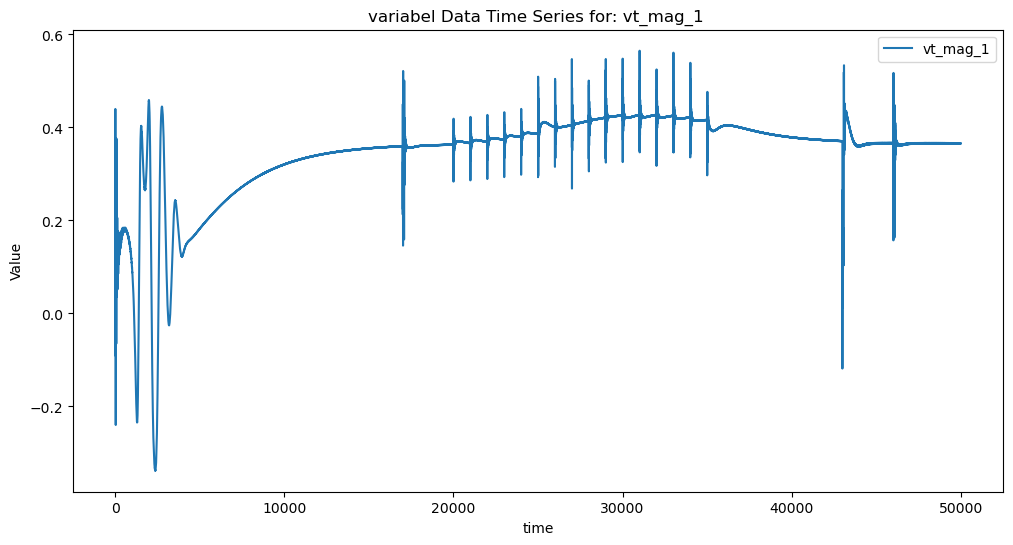

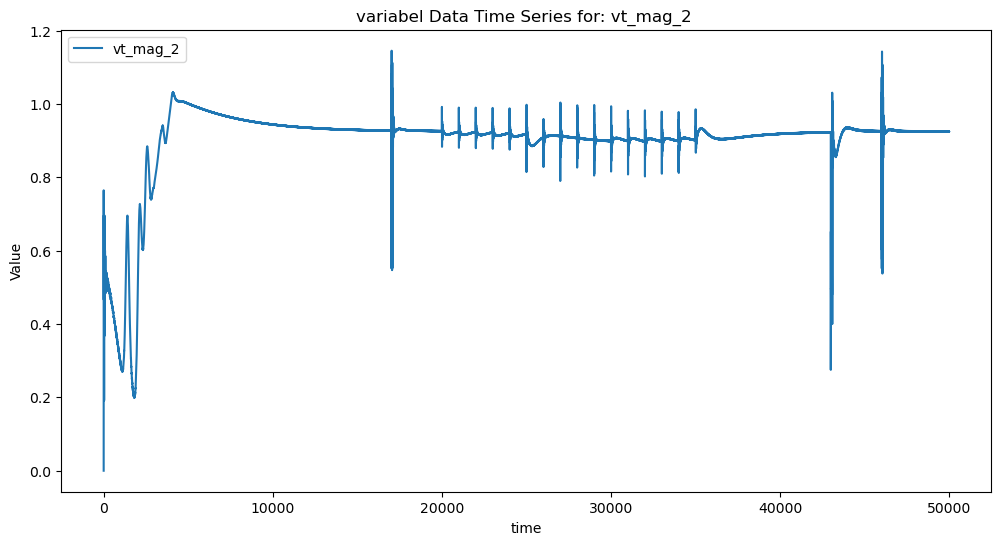

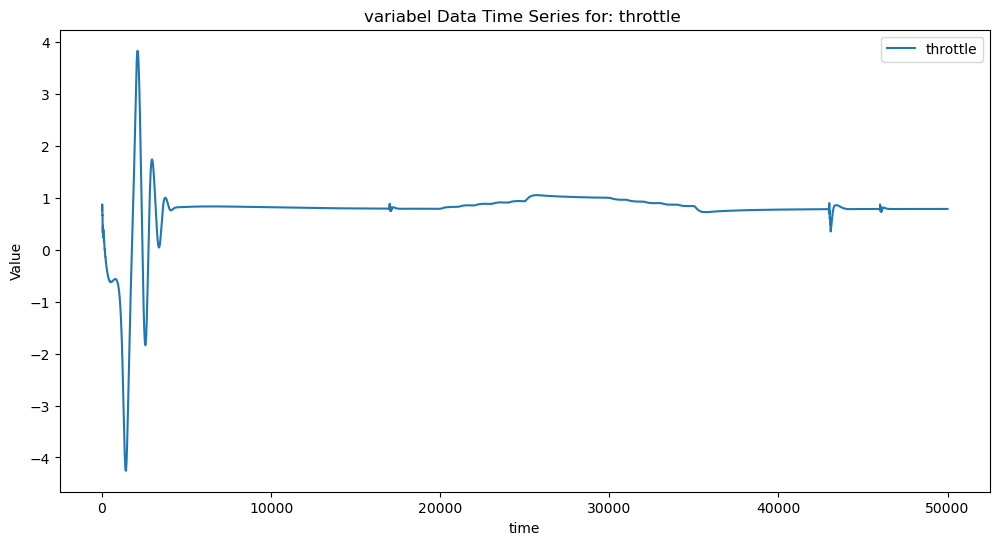

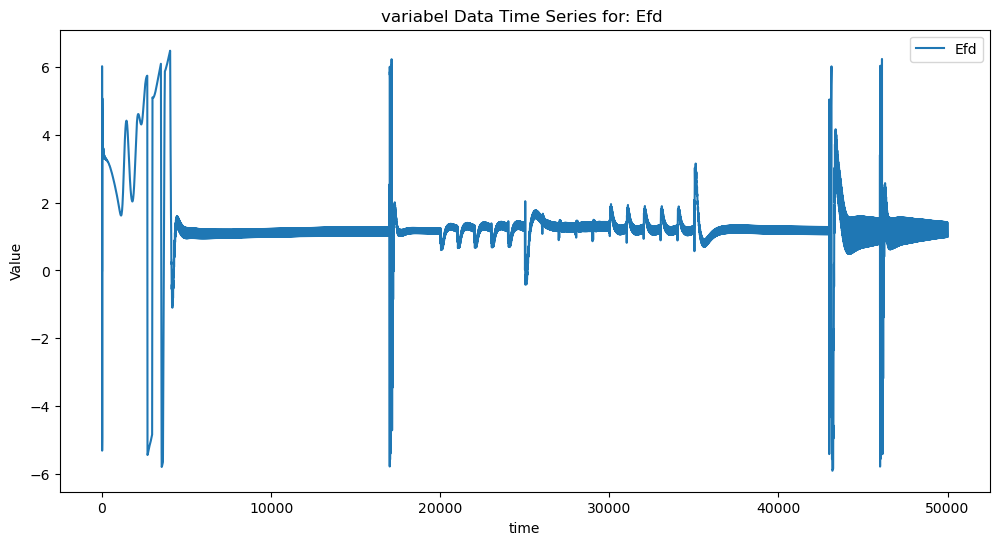

In [6]:
cols = list(data.columns)
for col in cols:
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data[col], label=col)
    plt.xlabel("time")
    plt.ylabel("Value")
    plt.title(f"variabel Data Time Series for: {col} ")
    plt.legend()
    plt.show()

In [7]:
#normalization stuff:(if you run this cell twice repeat the previous cells to avoud doube normalization.)
cols_to_normlze = cols[3:]

data[cols_to_normlze] = (data[cols_to_normlze] - data[cols_to_normlze].min()) / \
                                       (data[cols_to_normlze].max() - data[cols_to_normlze].min())

In [8]:
dataNorm = data

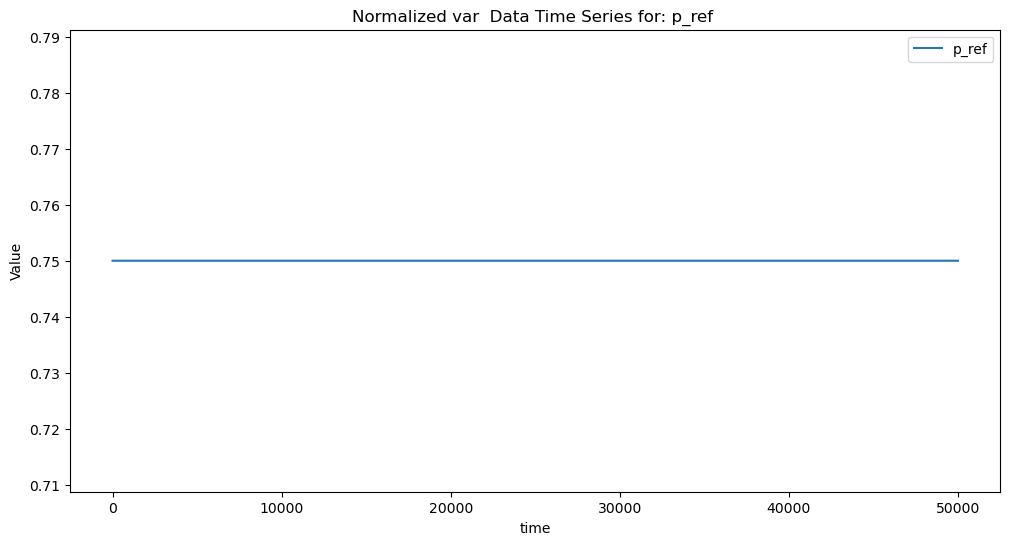

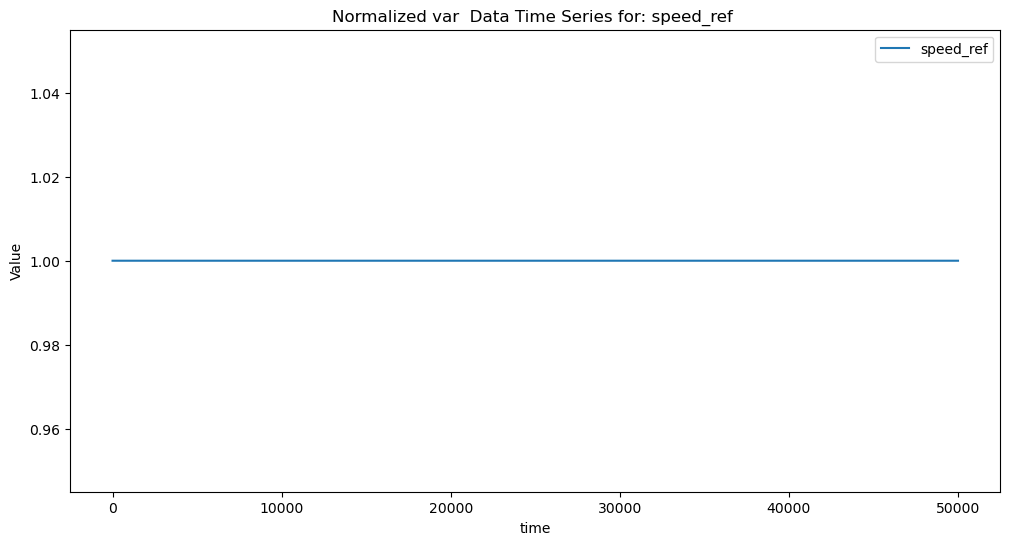

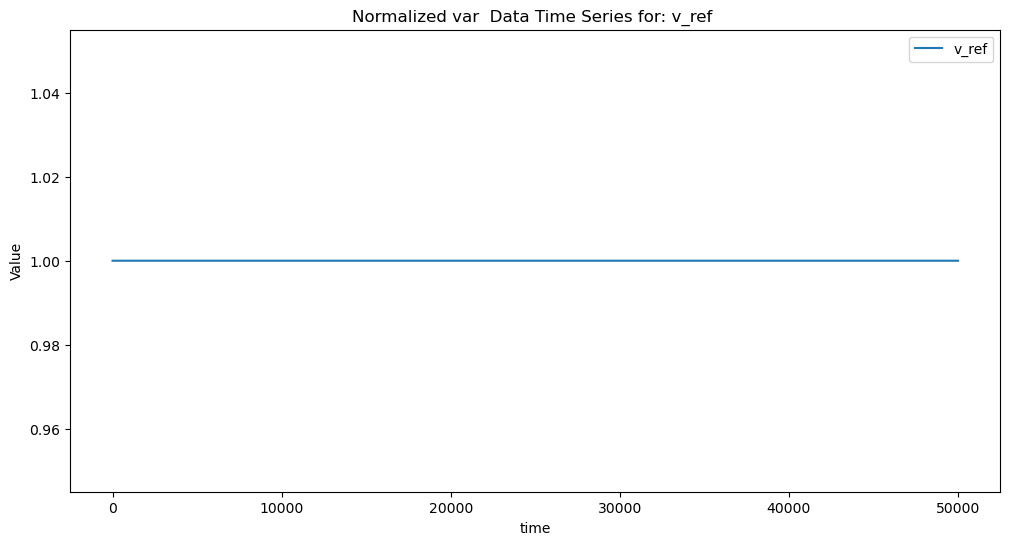

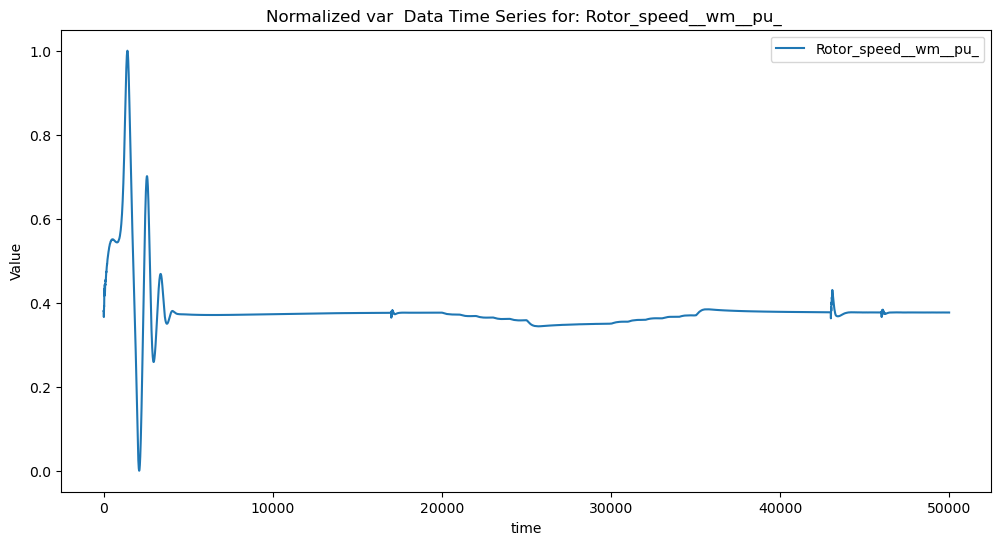

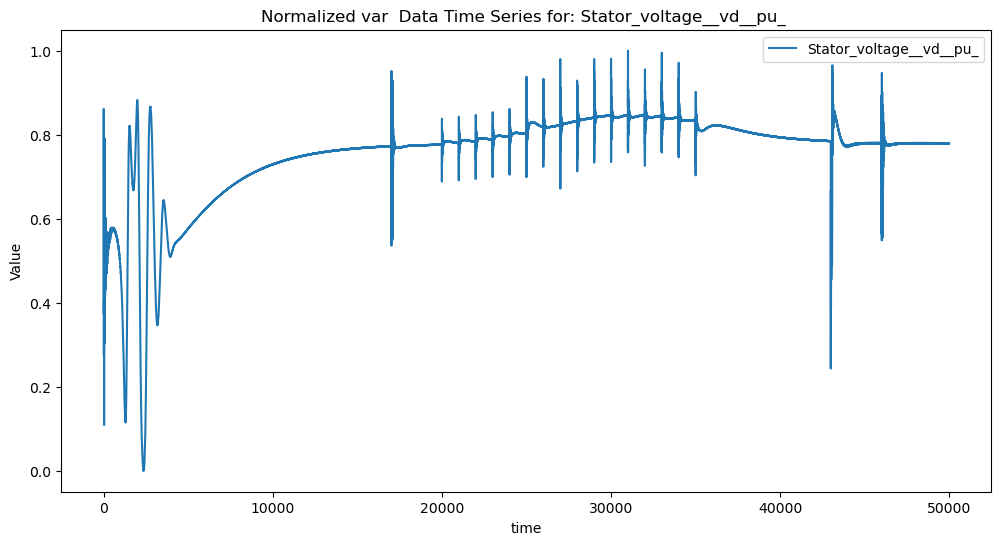

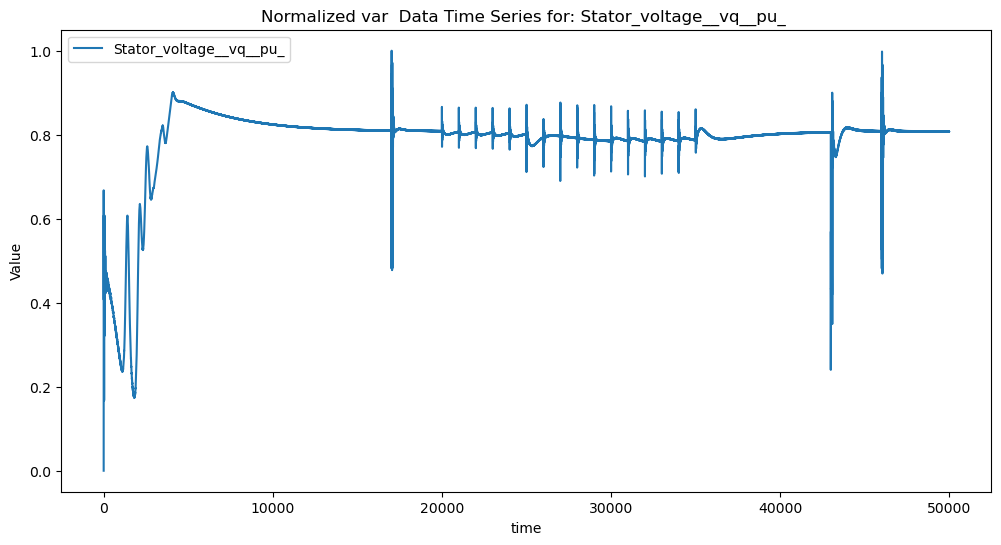

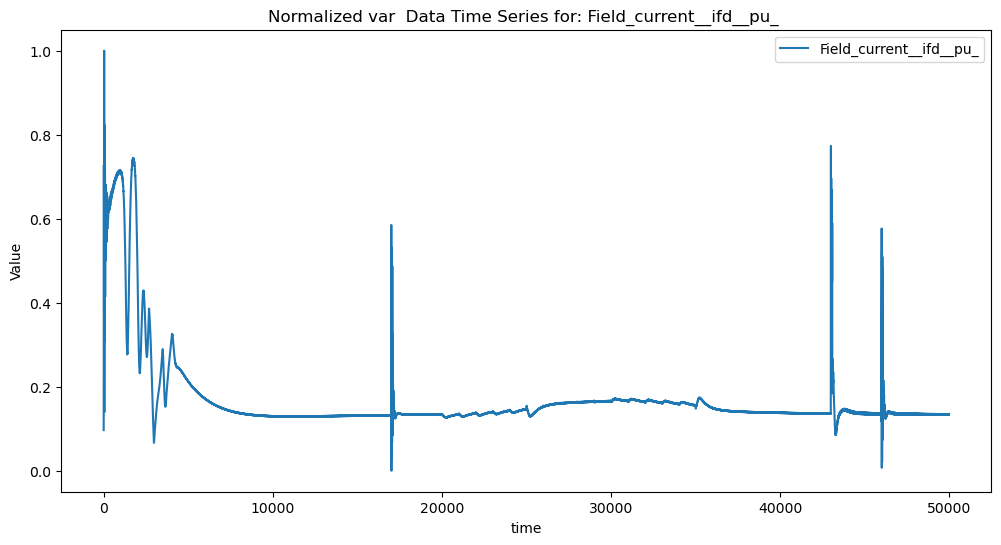

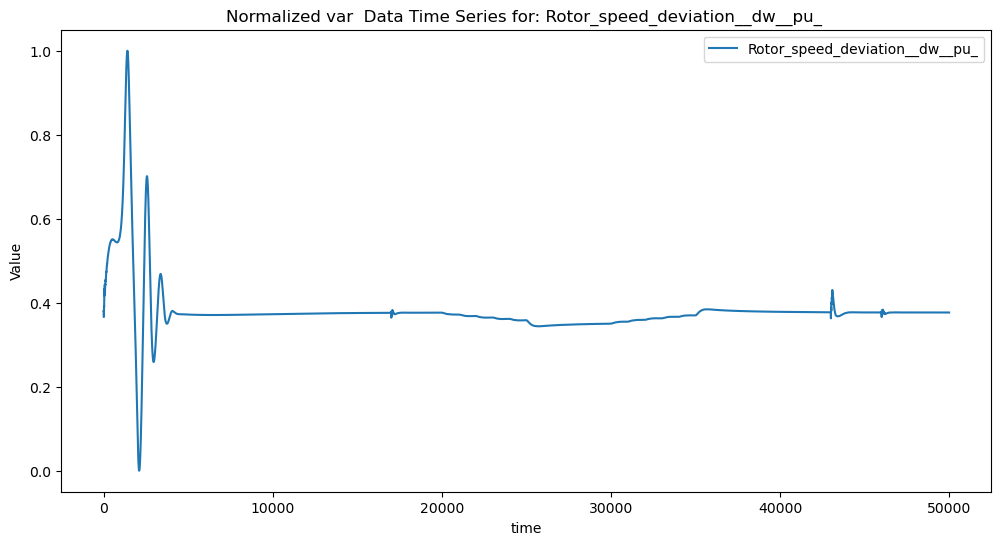

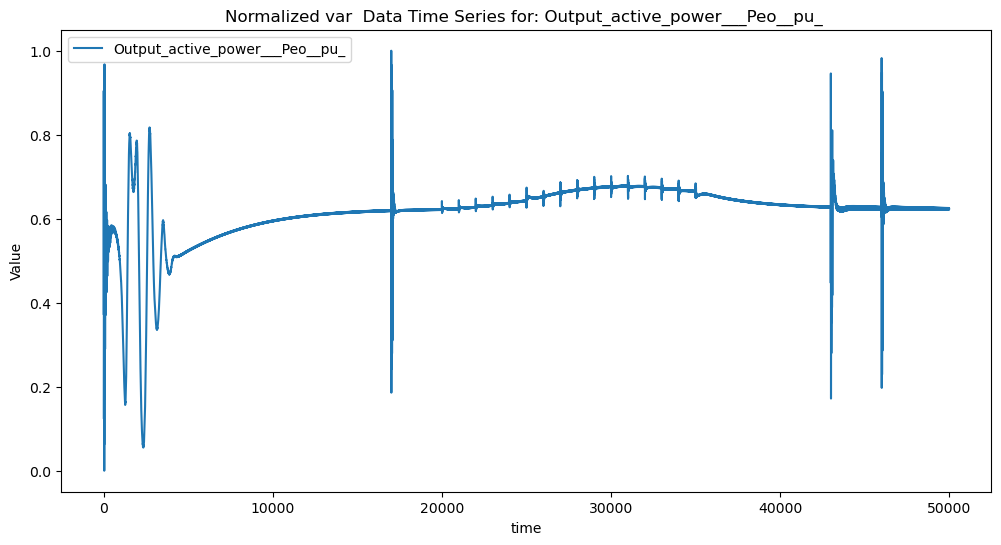

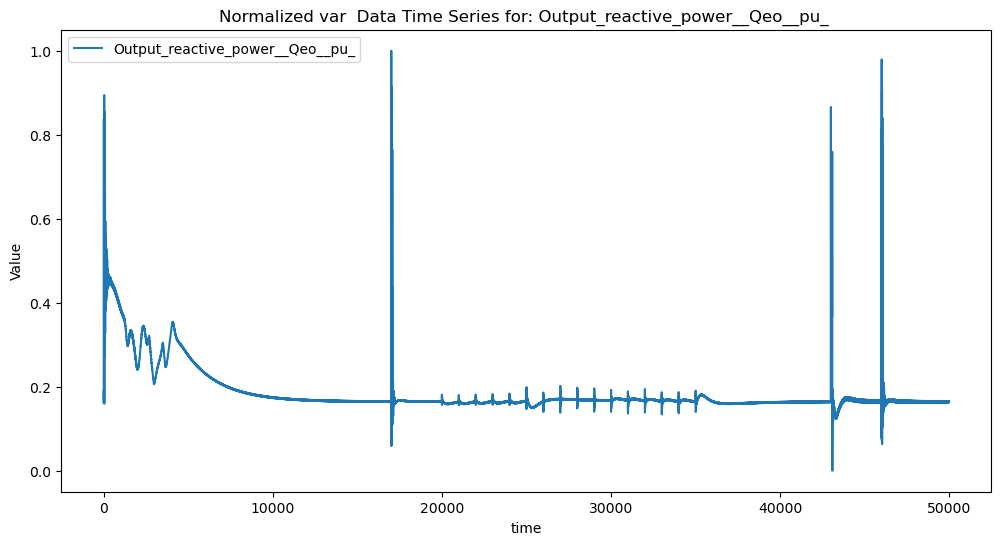

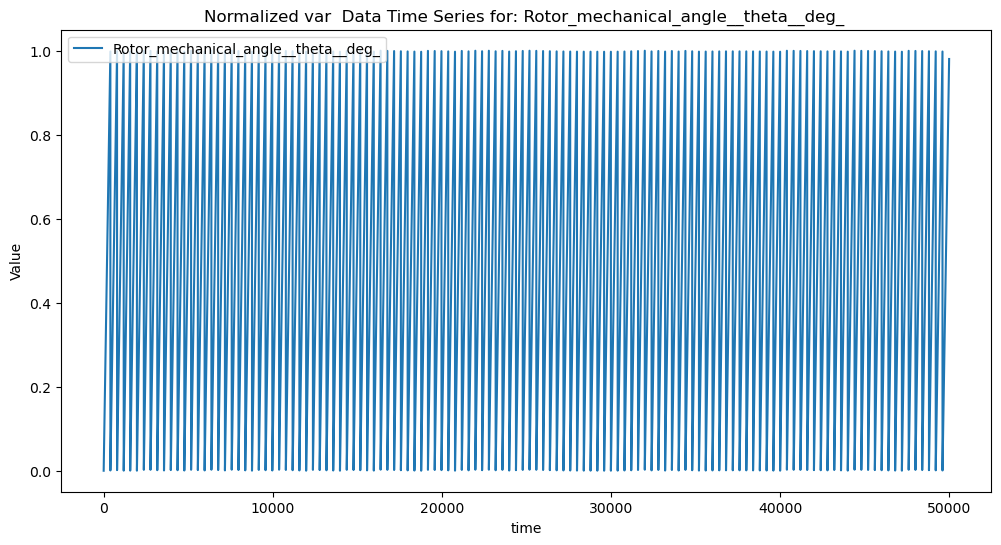

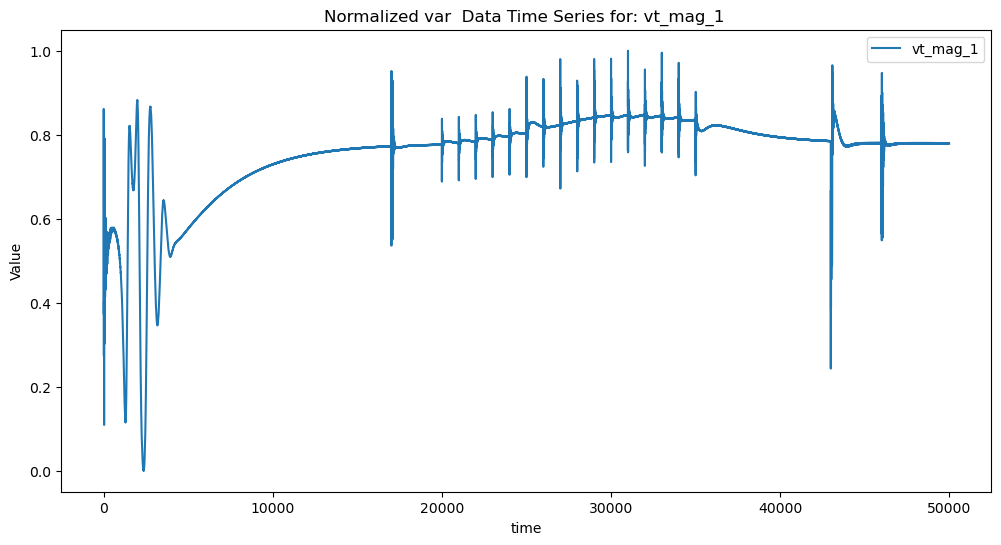

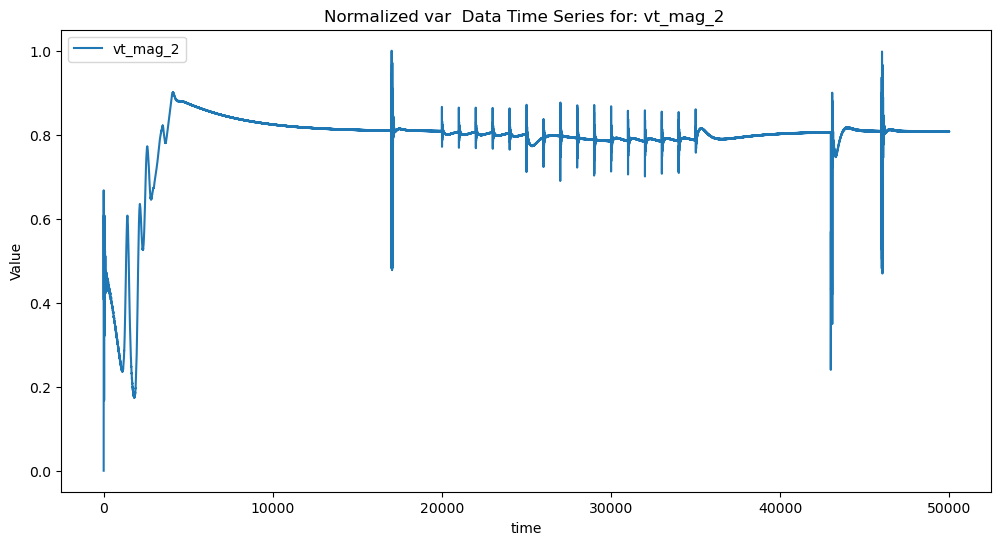

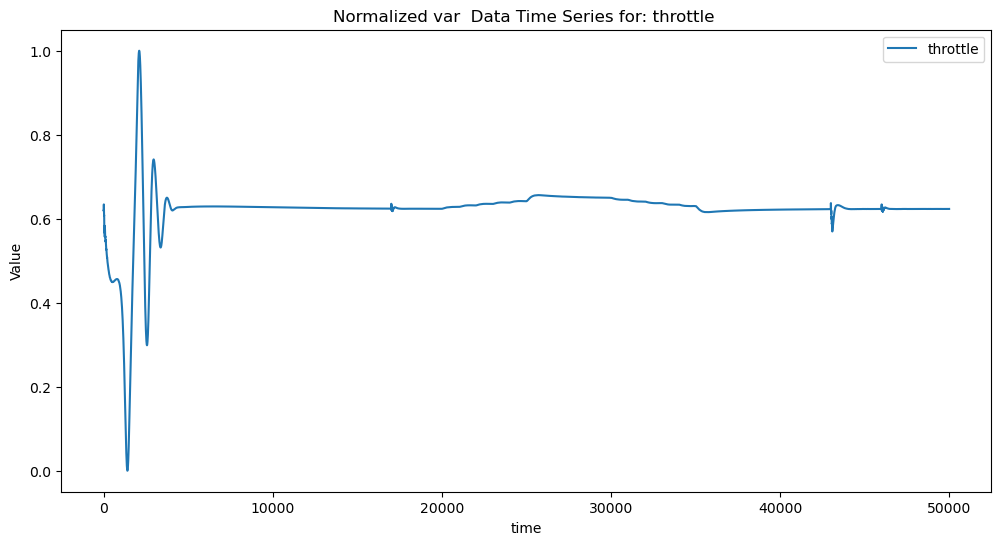

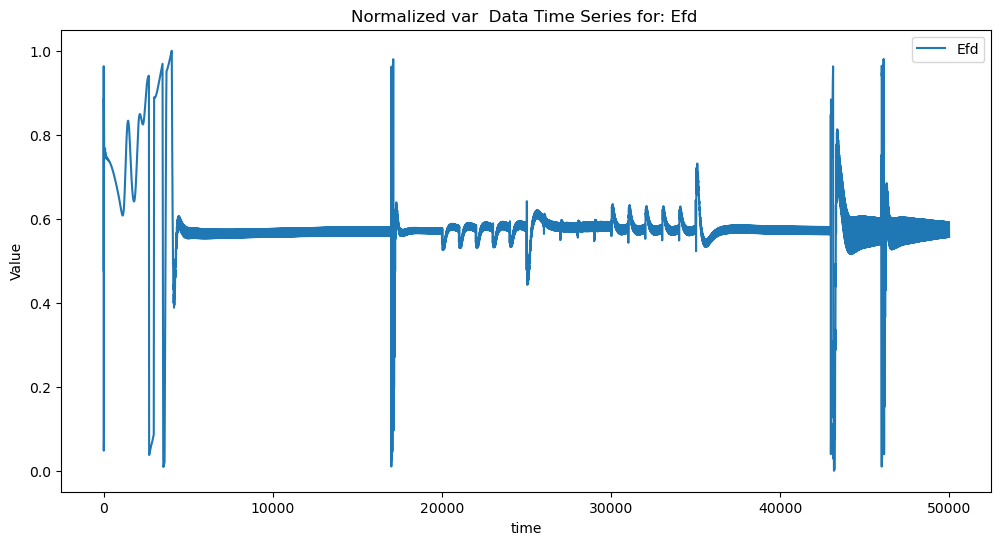

In [9]:
for col in cols:
    plt.figure(figsize=(12, 6))
    plt.plot(dataNorm.index, dataNorm[col], label=col)
    plt.xlabel("time")
    plt.ylabel("Value")
    plt.title(f"Normalized var  Data Time Series for: {col} ")
    plt.legend()
    plt.show()

the first 3 vars are left as they are constant ones. Also, we see there are no missing values, there are no negetive values.
We also do not see any extreme data in the plots, anways we would like ro capture all temporal correlations

EDA of the current conditions

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
from scipy.fft import fft

#predifined functions
def align_series(ts1, ts2):
    """Align two pandas Series on their common datetime index."""
    common_index = ts1.index.intersection(ts2.index)
    return ts1.loc[common_index], ts2.loc[common_index]

def euclidean_distance(ts1, ts2):
    """Compute direct Euclidean distance between two time series."""
    s1, s2 = align_series(ts1, ts2)
    if len(s1) == 0:
        return np.nan
    return np.linalg.norm(s1.values - s2.values)

def fft_euclidean_distance(ts1, ts2):
    """Compute Euclidean distance between FFT magnitudes of two time series."""
    s1, s2 = align_series(ts1, ts2)
    if len(s1) == 0:
        return np.nan
    # Compute FFT for each series
    fft1 = fft(s1.values)
    fft2 = fft(s2.values)
    # Compare the magnitudes (absolute values)
    return np.linalg.norm(np.abs(fft1) - np.abs(fft2))

def kl_divergence(p, q, eps=1e-10):
    """
    Compute the KL divergence from p to q.
    p and q should be numpy arrays that sum to 1.
    """
    p = p + eps
    q = q + eps
    return np.sum(p * np.log(p / q))

def symmetric_kl(ts1, ts2, eps=1e-10):
    """
    Compute a symmetric KL divergence between two time series.
    The series are converted to probability distributions by subtracting the minimum
    (to ensure non-negativity) and normalizing so the sum is 1.
    """
    s1, s2 = align_series(ts1, ts2)
    if len(s1) == 0:
        return np.nan
    # Shift series so that the minimum is zero (if needed)
    arr1 = s1.values - s1.values.min()
    arr2 = s2.values - s2.values.min()
    # Normalize to form probability distributions.
    p = arr1 / (arr1.sum() + eps)
    q = arr2 / (arr2.sum() + eps)
    return 0.5 * (kl_divergence(p, q, eps) + kl_divergence(q, p, eps))

def wavelet_energy_distance(ts1, ts2, wavelet='db1', level=None):
    """
    Compute the Euclidean distance between the normalized wavelet energy distributions
    of two time series.
    The energy at each level is computed as the sum of squares of the coefficients.
    """
    s1, s2 = align_series(ts1, ts2)
    if len(s1) == 0:
        return np.nan
    # Compute the discrete wavelet transform decomposition.
    coeffs1 = pywt.wavedec(s1.values, wavelet, level=level)
    coeffs2 = pywt.wavedec(s2.values, wavelet, level=level)
    # Compute energy for each set of coefficients.
    energy1 = np.array([np.sum(c**2) for c in coeffs1])
    energy2 = np.array([np.sum(c**2) for c in coeffs2])
    # Normalize energy vectors so they sum to 1.
    energy1 = energy1 / energy1.sum()
    energy2 = energy2 / energy2.sum()
    return np.linalg.norm(energy1 - energy2)

In [11]:
vars_to_compare = cols[-2:]      # 'throttle', 'Efd'
candidate_vars = cols[:-2]       # everything else
results = []

for mcol in vars_to_compare:
    for ccol in candidate_vars:
        ts_compare = dataNorm[mcol]
        ts_candidate = dataNorm[ccol]

        ed = euclidean_distance(ts_compare, ts_candidate)
        fft_ed = fft_euclidean_distance(ts_compare, ts_candidate)
        kl_div = symmetric_kl(ts_compare, ts_candidate)
        wavelet_ed = wavelet_energy_distance(ts_compare, ts_candidate, wavelet='db1')

        results.append({
            "Measured": mcol,
            "Compared With": ccol,
            "Euclidean": ed,
            "FFT Euclidean": fft_ed,
            "KL Divergence": kl_div,
            "Wavelet Energy Distance": wavelet_ed
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

    Measured                        Compared With   Euclidean  FFT Euclidean  \
0   throttle                                p_ref   32.457919    7257.883888   
1   throttle                            speed_ref   86.039021   19239.102255   
2   throttle                                v_ref   86.039021   19239.102255   
3   throttle                 Rotor_speed__wm__pu_   61.788185   12103.963773   
4   throttle              Stator_voltage__vd__pu_   38.198671    7544.166885   
5   throttle              Stator_voltage__vq__pu_   41.911680    8832.309175   
6   throttle              Field_current__ifd__pu_  106.151421   22787.192046   
7   throttle       Rotor_speed_deviation__dw__pu_   61.788185   12103.963773   
8   throttle       Output_active_power___Peo__pu_   19.667383    2202.876149   
9   throttle      Output_reactive_power__Qeo__pu_  100.050752   21862.074325   
10  throttle  Rotor_mechanical_angle__theta__deg_   71.643073   15943.838400   
11  throttle                            

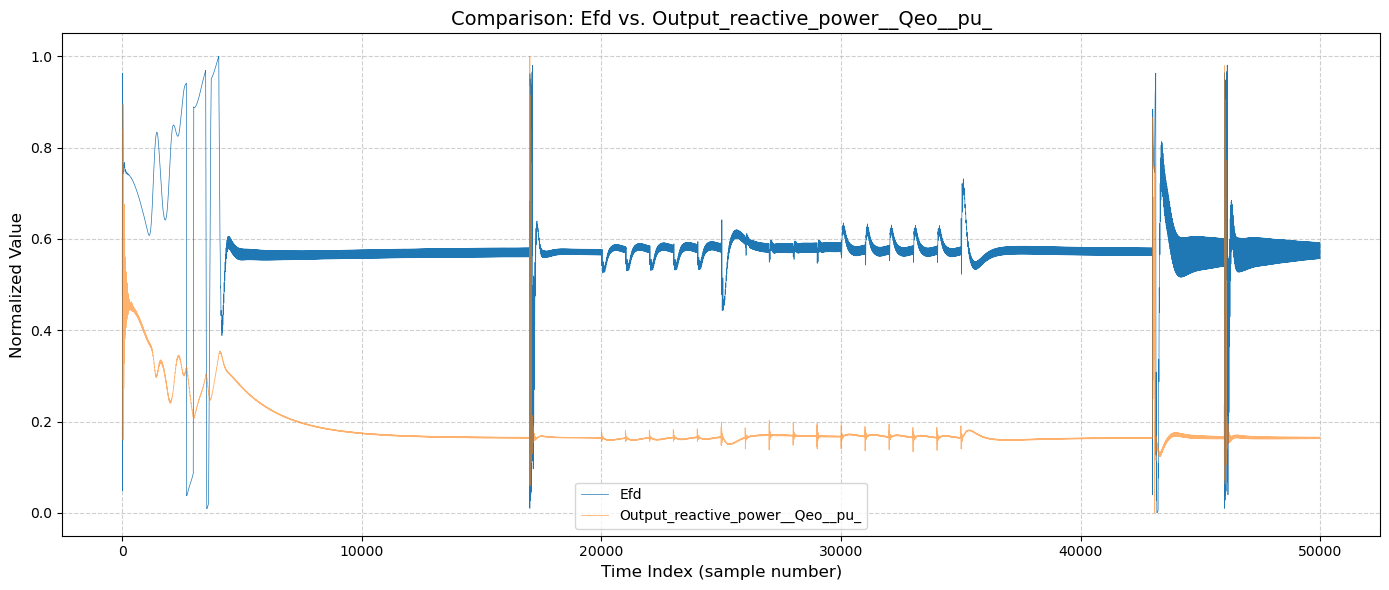

In [12]:
example_measured = 'Efd'
example_candidate = candidate_vars[9]

plt.figure(figsize=(14, 6))

plt.plot(
    dataNorm.index, dataNorm[example_measured],
    label=example_measured,
    color='tab:blue',
    linewidth=0.5,
    alpha=1
)

plt.plot(
    dataNorm.index, dataNorm[example_candidate],
    label=example_candidate,
    color='tab:orange',
    linewidth=0.6,
    alpha=0.6
)


plt.xlabel("Time Index (sample number)", fontsize=12)
plt.ylabel("Normalized Value", fontsize=12)
plt.title(f"Comparison: {example_measured} vs. {example_candidate}", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

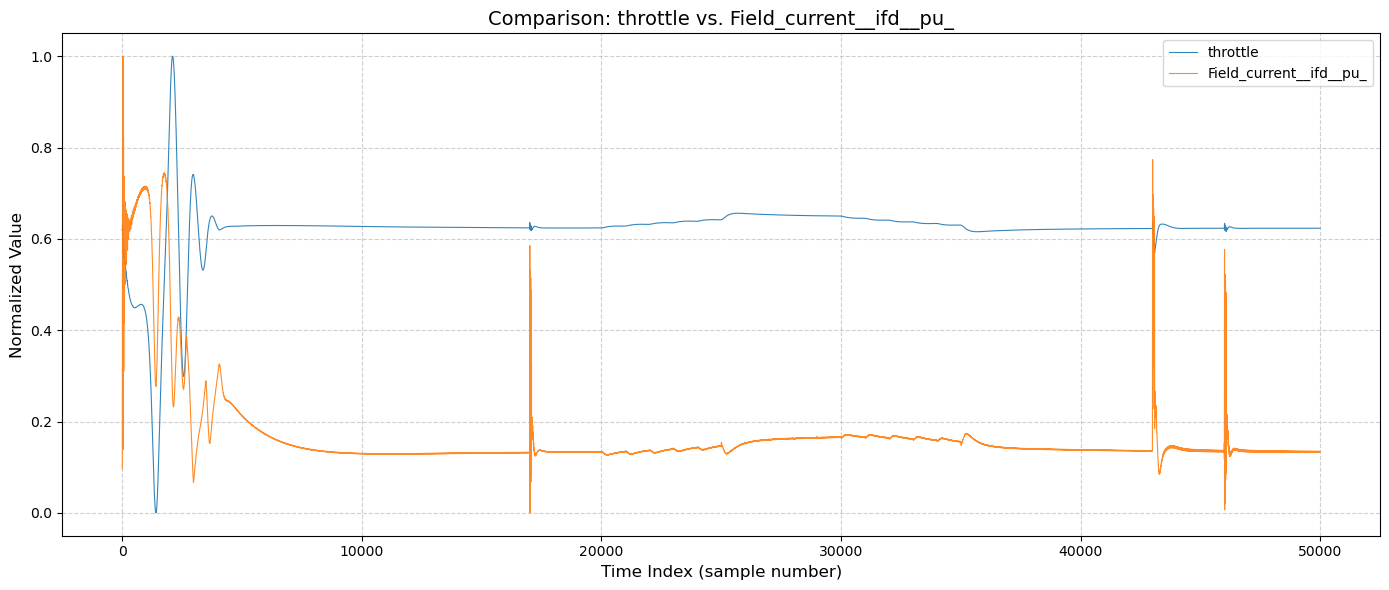

In [13]:
example_measured = 'throttle'
example_candidate= candidate_vars[6]

plt.figure(figsize=(14, 6))

plt.plot(
    dataNorm.index, dataNorm[example_measured],
    label=example_measured,
    color='tab:blue',
    linewidth=0.8,
    alpha=0.9
)

plt.plot(
    dataNorm.index, dataNorm[example_candidate],
    label=example_candidate,
    color='tab:orange',
    linewidth=0.8,
    alpha=0.9
)


plt.xlabel("Time Index (sample number)", fontsize=12)
plt.ylabel("Normalized Value", fontsize=12)
plt.title(f"Comparison: {example_measured} vs. {example_candidate}", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [14]:
print(dataNorm.shape)

(50001, 15)


In [15]:
dataNorm.head()

,p_ref,speed_ref,v_ref,Rotor_speed__wm__pu_,Stator_voltage__vd__pu_,Stator_voltage__vq__pu_,Field_current__ifd__pu_,Rotor_speed_deviation__dw__pu_,Output_active_power___Peo__pu_,Output_reactive_power__Qeo__pu_,Rotor_mechanical_angle__theta__deg_,vt_mag_1,vt_mag_2,throttle,Efd
0,0.75,1,1,0.380912,0.374402,0.000000,0.096727,0.380912,0.373560,0.190089,0.0000,0.374402,0.000000,0.619088,0.476857
1,0.75,1,1,0.381622,0.606115,0.667601,0.116495,0.381622,0.544900,0.181103,0.0025,0.606115,0.667601,0.618378,0.758528
2,0.75,1,1,0.381309,0.746713,0.576531,0.161922,0.381309,0.658722,0.167618,0.0050,0.746713,0.576531,0.618691,0.963092
3,0.75,1,1,0.380134,0.861303,0.522378,0.234389,0.380134,0.792504,0.161066,0.0075,0.861303,0.522378,0.619866,0.952555
4,0.75,1,1,0.378216,0.793488,0.429109,0.321559,0.378216,0.830892,0.205997,0.0100,0.793488,0.429109,0.621784,0.943604


In [16]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping

2025-04-22 15:10:01.047634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-22 15:10:01.057463: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-22 15:10:01.060471: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-22 15:10:01.068652: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
class TimeSeriesGenerator(Sequence):
    def __init__(self, data, targets, batch_size, n_past, target_cols):
        self.data = data.astype(np.float32)
        self.targets = targets
        self.batch_size = batch_size
        self.n_past = n_past
        self.target_cols = target_cols

    def __len__(self):
        # Number of full batches (same for training or prediction)
        return (len(self.data) - self.n_past) // self.batch_size

    def __getitem__(self, idx):
        X = []
        y = []
        start = idx * self.batch_size
        end = min(start + self.batch_size, len(self.data) - self.n_past)

        for i in range(start, end):
            X.append(self.data[i:i + self.n_past])
            y.append(self.data[i + self.n_past, self.target_cols])

        return np.array(X), np.array(y)

In [18]:
data_np = dataNorm.to_numpy(dtype=np.float32)
target_cols = [-2, -1]  # throttle, Efd assumed as last two columns

# 70/30 split
split_idx = int(len(data_np) * 0.7)

train_data = data_np[:split_idx]
val_data = data_np[split_idx:]

batch_size = 16
n_past = 1000

train_gen = TimeSeriesGenerator(train_data, train_data, batch_size, n_past, target_cols)
val_gen = TimeSeriesGenerator(val_data, val_data, batch_size=16, n_past=1000, target_cols=[-2, -1])

# ================================
#  Define Model
# ================================
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(n_past, train_data.shape[1])),
    Dropout(0.2),
    LSTM(64, activation='tanh'),
    Dropout(0.2),
    Dense(2)  # predicting throttle and Efd
])

model.compile(optimizer='adam', loss=Huber(delta=1.0))
model.summary()

# ================================
#  Setup Callbacks 
# ================================
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

I0000 00:00:1745334609.345675   24357 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1745334609.419308   24357 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1745334609.419582   24357 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1745334609.420838   24357 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1000, 128)      │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1000, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,266 (481.51 KB)

 Trainable params: 123,266 (481.51 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# ================================
#  Train Model
# ================================
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=80,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/80


/home/exouser/.conda/envs/my5920_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-04-22 15:10:17.587185: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


2125/2125 ━━━━━━━━━━━━━━━━━━━━ 140s 64ms/step - loss: 0.0053 - val_loss: 4.8332e-04
Epoch 2/80
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 137s 64ms/step - loss: 0.0010 - val_loss: 4.0589e-04
Epoch 3/80
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 138s 65ms/step - loss: 6.6658e-04 - val_loss: 4.3260e-04
Epoch 4/80
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 137s 65ms/step - loss: 4.4493e-04 - val_loss: 1.3632e-04
Epoch 5/80
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 138s 65ms/step - loss: 3.1846e-04 - val_loss: 1.3341e-04
Epoch 6/80
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 137s 65ms/step - loss: 2.0592e-04 - val_loss: 1.3930e-04
Epoch 7/80
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 137s 65ms/step - loss: 2.1939e-04 - val_loss: 3.1079e-04
Epoch 8/80
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 137s 64ms/step - loss: 1.7960e-04 - val_loss: 9.7505e-05
Epoch 9/80
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 138s 65ms/step - loss: 2.1453e-04 - val_loss: 1.1100e-04
Epoch 10/80
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 137s 65ms/step - loss: 1.6554e-04 - val_loss: 9.0726e-05
Epoch 11/80
2125/2125 ━━━━━━

In [20]:
model.save("lstm_throttle_efd_v1s1.h5")

In [21]:
predictions = model.predict(val_gen, verbose=1)
print(predictions.shape)

875/875 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step
(14000, 2)


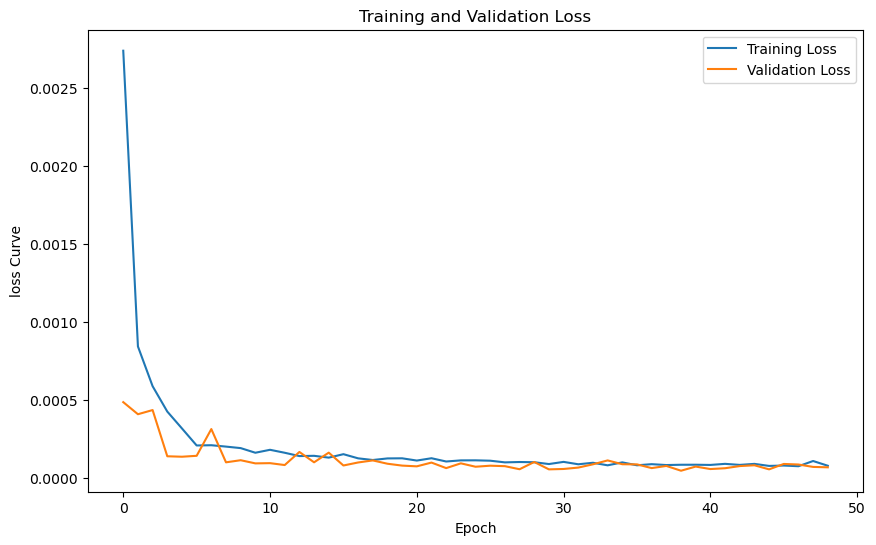

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('loss Curve')
plt.legend()
plt.show()

In [23]:
# Load original CSV
data_df_renorm = pd.read_csv('signals_exported.csv')
data12 = data_df_renorm #just so it is easy to type
data12 = data12.drop(columns=['time'])

# Original unnormalized target values
true_target = data12[['throttle', 'Efd']].to_numpy()


# 1. Pull the same min/max values from the original unnormalized data
min_vals = data12[['throttle', 'Efd']].min()
max_vals = data12[['throttle', 'Efd']].max()

# 2. Unnormalize predictions column-wise
predictions_unnorm = predictions.copy()
for i, col in enumerate(['throttle', 'Efd']):
    predictions_unnorm[:, i] = predictions[:, i] * (max_vals[col] - min_vals[col]) + min_vals[col]

# First 35000 rows: use actual target
part1 = true_target[:35000]

# Rows 35000 → 35999: input-only section, no predictions → use original
buffer_part = true_target[35000:36000]  # 1000 rows

# Rows 36000 → 49999: fill with model predictions (14000 rows)
pred_part = predictions_unnorm[:14000]  # Just to be safe, clip it

# Row 50000: use final original row to get back to 50001
last_row = true_target[-1:]  # shape (1, 2)

# Combine everything
final_output = np.vstack([part1, buffer_part, pred_part, last_row])

# Check shape
assert final_output.shape == (50001, 2), f"Final shape is {final_output.shape}, expected (50001, 2)"

# Save to CSV
df_out = pd.DataFrame(final_output, columns=['throttle', 'Efd'])
df_out.to_csv("simulink_input_final.csv", index=False)

print("Simulink-ready CSV saved as 'simulink_input_final.csv' with shape:", df_out.shape)

Simulink-ready CSV saved as 'simulink_input_final.csv' with shape: (50001, 2)


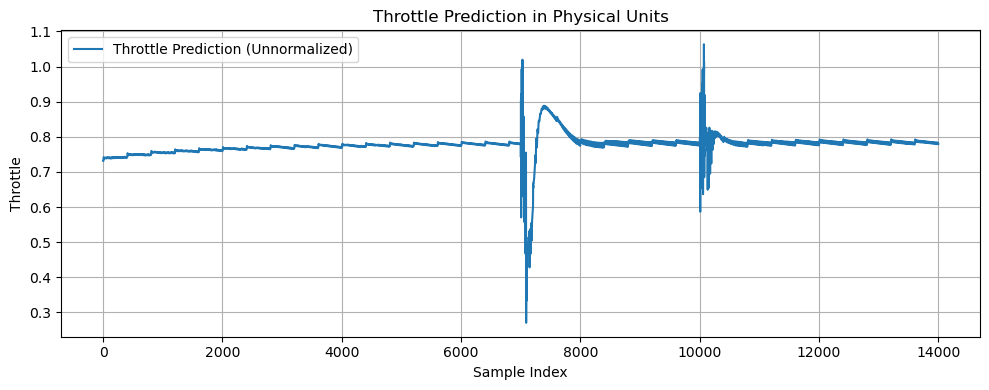

In [25]:
throttle_min = data12['throttle'].min()
throttle_max = data12['throttle'].max()

scale = throttle_max - throttle_min
un_norm_throttle = predictions[:, 0] * scale + throttle_min

plt.figure(figsize=(10, 4))
plt.plot(un_norm_throttle, label="Throttle Prediction (Unnormalized)")
plt.xlabel("Sample Index")
plt.ylabel("Throttle")
plt.title("Throttle Prediction in Physical Units")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
type(max_vals['throttle'].astype(np.float32))

numpy.float32

In [27]:
type(data12['throttle'].max())

float

In [28]:
print("Predicted throttle range:", un_norm_throttle.min(), "to", un_norm_throttle.max())
print("Original throttle range:", data12['throttle'].min(), "to", data12['throttle'].max())

Predicted throttle range: 0.2701621 to 1.06358
Original throttle range: -4.25547631473722 to 3.8297705884361
